# MNIST Dataset with Softmax

In this notebook, we will demonstrate how to use the JLNN to build a simple Multi-layer Perceptron to classify the MNIST dataset. First we will import all the required modules. We use `PyPlot` to plot the visualizations. We will also import necessary layers and a network essembler `SquentialNet` to build our simple architecture.

In [1]:
include("../src/NN.jl")
using NN
using PyPlot

# Data Preparation

In this section, we will prepare the MNIST dataset to train the classifier. MNIST dataset contains 60000 grey-scale images, each of which has dimensions 28x28. We will flatten these data so that each image will become a vector of 784 dimensions, and the label will be between 0 and 9.

We also split the data into training, validation and testing sets. The corresponding ratio of those data sets are 80%, 10% and 10%.

In [2]:
include("../util/datasets.jl")
X, Y = mnistData(ttl=50000)
println("Raw Datset Sizes: $(size(X)), $(size(Y))")

train_set, test_set, validation_set = datasplit(X, Y)
trX, trY   = train_set
valX, valY = validation_set
teX, teY   = test_set
size(trX),size(trY),size(valX),size(valY),size(teX),size(teY)

Raw Datset Sizes: (50000,784), (50000,1)


((40000,784),(40000,1),(5000,784),(5000,1),(5000,784),(5000,1))

# Network Structure

We use a really really simple network structure that contains a single Dense Layer and a softmax cross entropy loss. The output of the classifier is defined as:

$$y = softmax(Wx+b)$$
where function $softmax(v)$ is defined as:

$$softmax(x)_i = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$$

The loss function adapted the cross entropy function (which is a special case for KL-Divergence, when $p$, the ground truth probability is set to a hot vector):

$$\mathcal{L}=-\sum_{i}p_i\log{y_i}$$

The way to defined such classifier in JLNN is really simple:

In [3]:
function softmax_clf()
    layers = Layer[ FCLayer(784, 10) ]
    criteria = SoftMaxCrossEntropyLoss()
    net = SequentialNet(layers, criteria)
    return net
end
net = softmax_clf()

NN.SequentialNet(NN.Layer[NN.FCLayer(784,[0.0592182 -0.0608483 … 0.0239877 0.103325; -0.0896512 -0.026686 … 0.119454 -0.0950356; … ; 0.0504805 -0.0634868 … -0.0193588 0.0145266; 0.0 0.0 … 0.0 0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])],NN.SoftMaxCrossEntropyLoss(Float64[],Float64[],Float64[],Float64[],Float64[],Int64[],[1],0:0))

# Training and Optimizations

In this section, we train our network to learn the MNIST dataset. The network is consist of one FC layer, one cross-Entropy with soft max layer, and one sequential net. The training function we choose is the simple stochastic gradient descent.

In [4]:
function get_corr(pred, answ)
    return length(filter(e -> abs(e) < 1e-5, pred-answ))
end
function train(net::SequentialNet, X, Y; 
    batch_size::Int64 = 64, ttl_epo::Int64 = 10, lrSchedule = (x -> 0.01), verbose=0)
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local epo_accus = []
    local val_losses = []
    local val_accu   = []
    for epo = 1:ttl_epo
        local num_batch = ceil(N/batch_size)
        if verbose > 0
            println("Epo $(epo) num batches : $(num_batch)")
        end
        all_losses = []
        epo_cor = 0
        for bid = 0:(num_batch-1)
            batch += 1
            local sidx::Int = convert(Int64, bid*batch_size+1)
            local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
            local batch_X = X[sidx:eidx,:]
            local batch_Y = Y[sidx:eidx,:]
            loss, _ = forward(net, batch_X, batch_Y)
            backward(net, batch_Y)
            append!(all_losses, mean(loss))
            for i = 1:length(net.layers)
                local layer = net.layers[i]
                local gradi = lrSchedule(epo) * NN.gradient(layer) / batch_size
                local theta = getParam(layer) - gradi
                if verbose > 2
                    print("Layer $(i)")
                    print("\tGradient: $(sum(abs(theta - getLDiff(layer))))")
                    if verbose > 1
                        print("\tLastloss: $(sum(abs(layer.last_loss)))")
                    end
                    println()
                end
                setParam!(layer, theta)
            end

            _, pred = forward(net, batch_X, batch_Y; deterministics = true)
            epo_cor  += length(filter(e ->  abs(e) < 1e-5, pred - batch_Y))
            local acc = length(filter(e -> abs(e) < 1e-5, pred - batch_Y)) / batch_size
            if verbose > 1
                println("[$(bid)/$(num_batch)]Loss is: $(loss)\tAccuracy:$(acc)")
            end
        end
        
        local epo_loss = mean(all_losses)
        local epo_accu = epo_cor / N
        append!(epo_losses, epo_loss)
        append!(epo_accus, epo_accu)
        v_loss, v_pred = forward(net, valX, valY)
        v_size = size(valX)[1]
        v_accu = get_corr(v_pred, valY) / v_size
        append!(val_losses, mean(v_loss))
        append!(val_accu,   v_accu)
        if epo % 10 == 0
            println("Epo $(epo) has loss :$(epo_loss)\t\taccuracy : $(epo_accu)")
            println("Validation accuracy : $(v_accu)")
        end
        if verbose > 0
            println("Epo $(epo) has loss :$(mean(epo_loss))\t\taccuracy : $(epo_accu)")
        end
    end
    return epo_losses,epo_accus,val_losses,val_accu
end

train (generic function with 1 method)

Epo 10 has loss :0.4238969716609566		accuracy : 0.8855
Validation accuracy : 0.8928
Epo 20 has loss :0.36535081222741966		accuracy : 0.8996
Validation accuracy : 0.903
Epo 30 has loss :0.34030168303101116		accuracy : 0.906025
Validation accuracy : 0.9082
Epo 40 has loss :0.3253619346715784		accuracy : 0.91015
Validation accuracy : 0.9108
Epo 50 has loss :0.31508279382055554		accuracy : 0.91335
Validation accuracy : 0.9124
Epo 60 has loss :0.3074175062666656		accuracy : 0.9154
Validation accuracy : 0.9158
Epo 70 has loss :0.30139625657016433		accuracy : 0.9169
Validation accuracy : 0.9178
Epo 80 has loss :0.29649025743173796		accuracy : 0.917925
Validation accuracy : 0.9186
Epo 90 has loss :0.2923827086676571		accuracy : 0.919175
Validation accuracy : 0.9188
Epo 100 has loss :0.2888705113455806		accuracy : 0.9201
Validation accuracy : 0.9192
Epo 110 has loss :0.28581660741193166		accuracy : 0.92095
Validation accuracy : 0.9198
Epo 120 has loss :0.28312469239044574		accuracy : 0.92205
Va

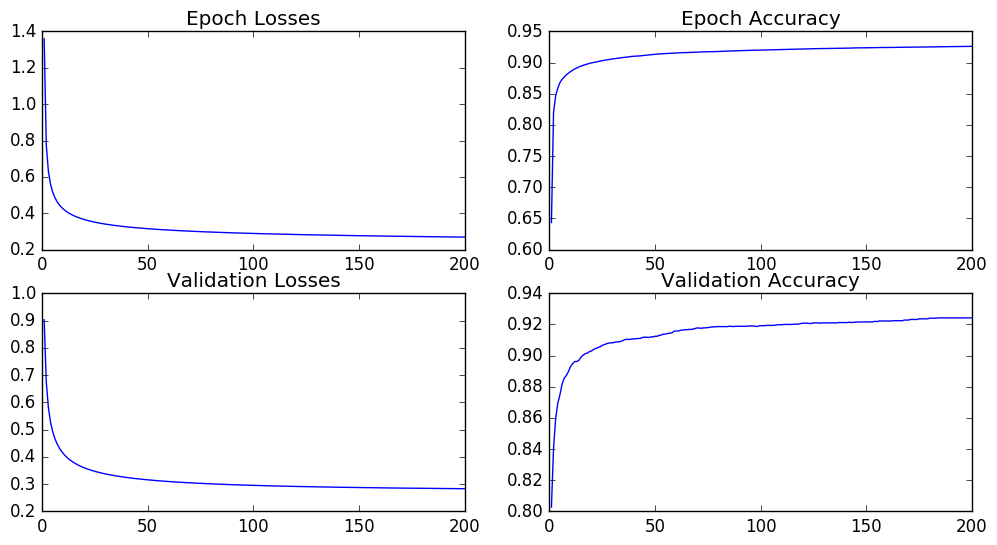

Epo 200 has loss :0.2689149443576787		accuracy : 0.926075
Validation accuracy : 0.9242


In [5]:
net = softmax_clf()

losses,accus,val_losses,val_accus = train(net, trX, trY;
    ttl_epo = 200, batch_size = 100, lrSchedule = x -> 0.01, verbose=0)

figure(figsize=(12,6))
subplot(221)
plot(1:length(losses), losses)
title("Epoch Losses")

subplot(222)
plot(1:length(accus), accus)
title("Epoch Accuracy")
show()

subplot(223)
plot(1: length(val_losses), val_losses)
title("Validation Losses")
show()

subplot(224)
plot(1: length(val_accus), val_accus)
title("Validation Accuracy")
show()


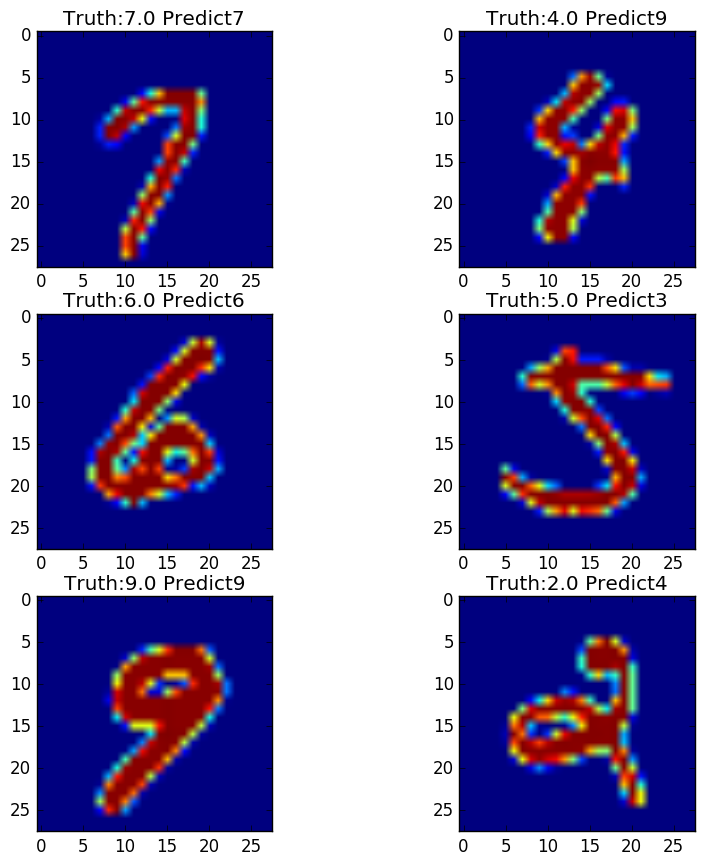

Testing Accuracy:0.9154


In [6]:
_, pred = forward(net, teX, teY; deterministics = true)
N = size(teX)[1]
corr = length(filter(i-> abs(pred[i] - teY[i]) <  1e-5, 1:N))
right_idx = filter(i-> abs(pred[i] - teY[i]) <  1e-5, 1:N)[1:3]
wrong_idx = filter(i-> abs(pred[i] - teY[i]) >= 1e-5, 1:N)[1:3]

println("Testing Accuracy:$(corr/N)")

figure(figsize=(10,10))
subplot(321)
imshow(reshape(teX[right_idx[1],:], 28,28))
title("Truth:$(teY[right_idx[1]]) Predict$(pred[right_idx[1]])")

subplot(322)
imshow(reshape(teX[wrong_idx[1],:], 28,28))
title("Truth:$(teY[wrong_idx[1]]) Predict$(pred[wrong_idx[1]])")

subplot(323)
imshow(reshape(teX[right_idx[2],:], 28,28))
title("Truth:$(teY[right_idx[2]]) Predict$(pred[right_idx[2]])")

subplot(324)
imshow(reshape(teX[wrong_idx[2],:], 28,28))
title("Truth:$(teY[wrong_idx[2]]) Predict$(pred[wrong_idx[2]])")

subplot(325)
imshow(reshape(teX[right_idx[3],:], 28,28))
title("Truth:$(teY[right_idx[3]]) Predict$(pred[right_idx[3]])")

subplot(326)
imshow(reshape(teX[wrong_idx[3],:], 28,28))
title("Truth:$(teY[wrong_idx[3]]) Predict$(pred[wrong_idx[3]])")
show()

# Use Gradient Descend to Generate Aversarial Images

In this section below, we will introduce how to use gradient descend on the input images to generate an adversarial training example that will differ from the original image by a really small difference.

The idea will be pretty simple: we will pick an image with that's originally classified to certain label, then we will propogate this image through the network compute the gradient of this image. Formally, suppose the image is $x$ and the network has output $f(x)$ with loss function $\mathcal{L}$, then we could use the simple backward pass to calculate $\frac{\partial \mathcal{L}}{\partial x}$. This value tells us the direction where we could move our images to increase the loss. Instead of updating the parameter of the layers, we will update the image to lower the loss:
$$x = x - \alpha \frac{\partial \mathcal{L}}{\partial x}$$

The surprising fact is that although the generated images almost remain the same, but the network will classify it incorrectly in to a different label.

Original Label:[6.0]	Target label:[9.0]


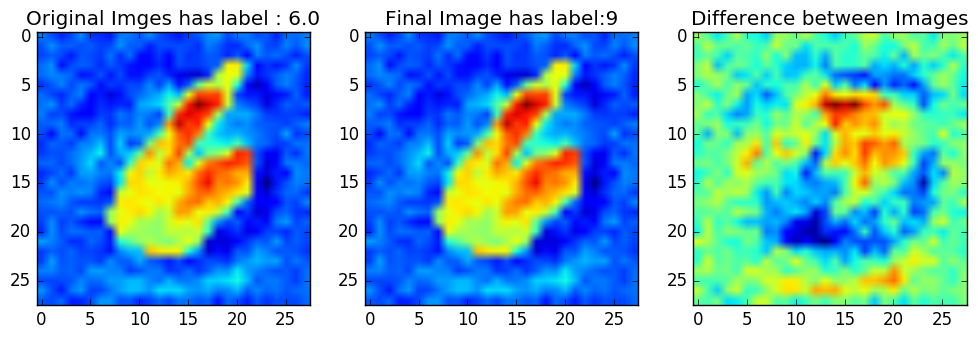

Average magtitude of the permutation:0.10493815962640982


In [8]:
idx   = convert(Int, ceil(rand() * size(trX)[1]))
alpha = 0.1
inpx  = trX[idx:idx,:]
t     = trY[idx:idx,:]

target = (t[1,:] + 3) % 10
println("Original Label:$(t[1,:])\tTarget label:$(target)")
t[1,:] = target
verbose = false
for i = 1:10000
    loss, _ = forward(net, inpx, t)
    dldx = backward(net, t)
    inpx -= alpha * dldx
    if i % 2000 == 1 && verbose
        println("Iteration $(i), loss:$(mean(loss)), dldx:$(sum(abs(dldx)))")
        figure(figsize=(2,2))
        imshow(reshape(inpx[1,:], 28,28))
        show()
    end
end

figure(figsize=(12,4))
subplot(131)
imshow(reshape(inpx, 28,28))
title("Original Imges has label : $(trY[idx])")

_, pred = forward(net, inpx, t)
subplot(132)
imshow(reshape(inpx[1,:], 28,28))
title("Final Image has label:$(pred[1])")

subplot(133)
imshow(reshape(inpx - trX[idx:idx,:], 28,28))
title("Difference between Images")
show()

println("Average magtitude of the permutation:$(mean(abs(inpx -trX[idx:idx,:])))")